In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time
import tensorflow.keras.backend as K

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [4]:
x_train = x_train/255
x_test = x_test/255

In [5]:
img_w = x_train.shape[1]
img_h = x_train.shape[2]
colour_channels = 1
input_shape = (img_h, img_w, colour_channels)

In [6]:
x_train = x_train.reshape(x_train.shape[0],img_h,img_w,colour_channels)
x_test = x_test.reshape(x_test.shape[0],img_h,img_w,colour_channels)

Text(0.5, 1.0, '6')

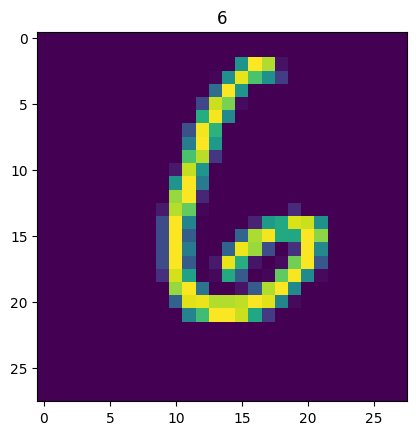

In [7]:
plt.figure()
plt.imshow(x_train[32])
plt.title(y_train[32])

In [8]:
latent_dim = 80

In [9]:

input_img = tf.keras.layers.Input(shape=input_shape, name='encoder_input')
x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)


conv_shape = K.int_shape(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

z_mu = tf.keras.layers.Dense(latent_dim, name='latent_mu')(x)   
z_sigma = tf.keras.layers.Dense(latent_dim, name='latent_sigma')(x) 


def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

z =tf.keras.layers.Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])


encoder = tf.keras.models.Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())


decoder_input = tf.keras.layers.Input(shape=(latent_dim, ), name='decoder_input')
x = tf.keras.layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x =tf.keras.layers. Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = tf.keras.layers.Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = tf.keras.layers.Conv2DTranspose(colour_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)
decoder = tf.keras.models.Model(decoder_input, x, name='decoder')
decoder.summary()
z_decoded = decoder(z)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [10]:

class CustomLayer(tf.keras.layers.Layer):

    def vae_loss(self, x, z_decoded, z_mu, z_sigma):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        recon_loss = tf.keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        z_mu = inputs[2]
        z_sigma = inputs[3]
        
        loss = self.vae_loss(x, z_decoded, z_mu, z_sigma)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomLayer()([input_img, z_decoded, z_mu, z_sigma])


In [11]:
vae = tf.keras.models.Model(input_img, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                                

In [12]:
vae.fit(x_train, None, epochs = 100, batch_size = 32, validation_split = 0.2)

Epoch 1/100
1500/1500 [==============================] - 10s 5ms/step - loss: 0.1509 - val_loss: 0.1182
Epoch 2/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1113 - val_loss: 0.1073
Epoch 3/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1040 - val_loss: 0.1036
Epoch 4/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1012 - val_loss: 0.1016
Epoch 5/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0994 - val_loss: 0.1007
Epoch 6/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0981 - val_loss: 0.0991
Epoch 7/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0971 - val_loss: 0.0987
Epoch 8/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0963 - val_loss: 0.0980
Epoch 9/100
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0956 - val_loss: 0.0975
Epoch 10/100
1500/1500 [==============================] - 7s 5ms/step - 

1/1 [==============================] - 0s 71ms/step


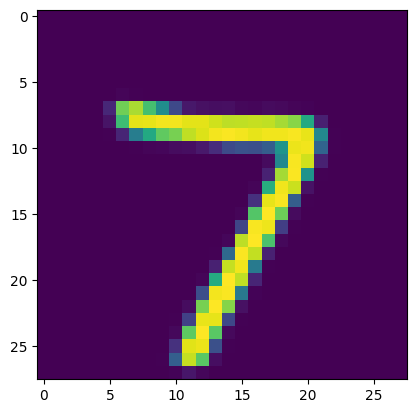

In [13]:
mu, _, _ = encoder.predict(tf.expand_dims(x_test[0],axis=0))
sample_vector = np.array([mu[0]])
decoded_example = decoder.predict(sample_vector)
decoded_example_reshaped = decoded_example.reshape(img_w, img_h)
plt.imshow(decoded_example_reshaped)

In [14]:
mu

array([[ 0.3068354 , -0.65161335,  2.070922  , -0.40691948, -0.49624985,
         0.04558975,  0.24736413,  2.3299034 , -1.5933907 , -2.5862644 ,
         1.5418621 , -0.03168105,  0.14786872,  0.00942504, -0.17303032,
         1.1890365 , -0.28187376, -0.48015344,  0.1256032 , -0.06669752,
        -0.09239087,  0.07942329,  3.1470404 ,  0.06504026,  1.6032804 ,
        -0.01011357, -0.5042261 , -0.5715908 , -0.6602379 , -0.17122814,
        -0.10042715,  1.9020896 , -0.01375258,  0.05700029,  0.22199945,
        -0.5231354 ,  0.26683858, -1.9223007 ,  0.78169626, -0.24839652,
        -0.05302149,  0.11920145,  0.8517693 ,  0.21110171, -1.1604125 ,
        -0.13786453,  0.13515937,  1.5565586 ,  0.17377698,  0.50819755,
         3.4892304 , -1.5923063 ,  0.1163913 ,  0.04900771,  0.11816822,
        -0.5782919 ,  0.20155299,  0.00913054, -0.04464004,  0.05860353,
        -1.748186  , -0.18394315, -0.24561578, -3.5900023 , -0.70582867,
         0.39433455,  1.806115  ,  2.5254726 ,  0.3

In [16]:
def predict_image(img,encoder,decoder,img_w, img_h):
    mu, _, _ = encoder.predict(tf.expand_dims(img,axis=0))
    sample_vector = np.array([mu[0]])
    decoded_example = decoder.predict(sample_vector)
    decoded_example_reshaped = decoded_example.reshape(img_w, img_h)
    plt.subplot(1, 2, 2)
    plt.title("Generated")
    plt.imshow(decoded_example_reshaped)
    
    real = img
    plt.subplot(1, 2, 1)
    plt.title("Real")
    plt.imshow(real)

1/1 [==============================] - 0s 12ms/step


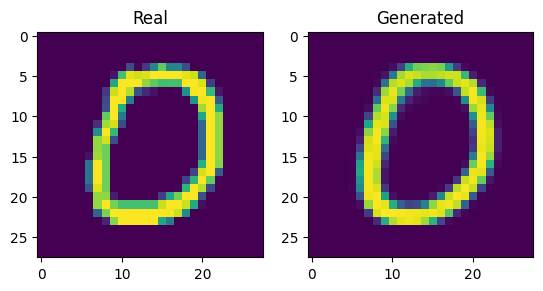

In [17]:
predict_image(x_test[10],encoder,decoder,img_w,img_h)

In [20]:
def preprocess(img_path):
    import cv2
    import numpy as np
    gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    # gray = 255 - img

    gray = cv2.resize(gray, (28, 28))
    cv2.imwrite('gray'+ img_path, gray)
    img = gray / 255.0
    img = np.array(img).reshape(28, 28, 1)
    return img

In [21]:
ig1 = preprocess('./stage (1).png')

NameError: name 'ig1' is not defined

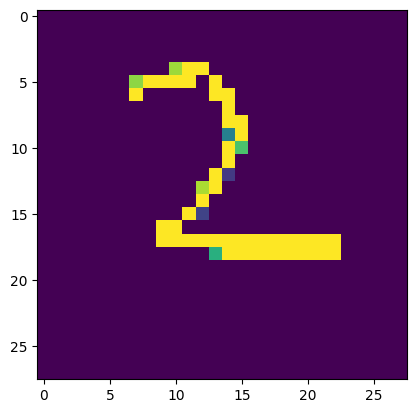

In [22]:
plt.imshow(ig1)

1/1 [==============================] - 0s 12ms/step


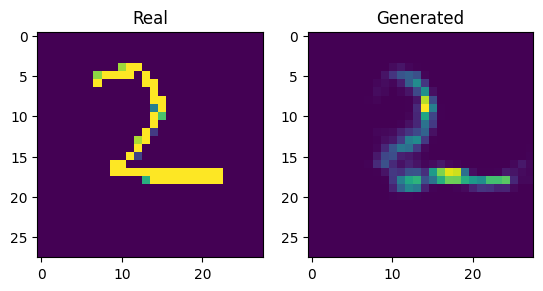

In [23]:
predict_image(ig1,encoder,decoder,img_h,img_w)

In [27]:
encoder.save('./models/encoderModel.keras')
decoder.save('./models/decoderModel.keras')
vae.save('./models/vaeModel.keras')

In [31]:
custom_objects = {"CustomLayer": CustomLayer}


reconstructed_vae =tf.keras.models.load_model("./models/vaeModel.keras",
                                              custom_objects={"CustomLayer": CustomLayer},
                                             )


reconstructed_decoder = tf.keras.models.load_model(
    "./models/decoderModel.keras",
    
)

reconstructed_encoder = tf.keras.models.load_model(
    "./models/encoderModel.keras",
    
)

1/1 [==============================] - 0s 44ms/step


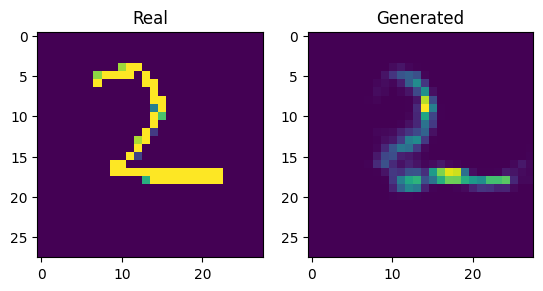

In [33]:

predict_image(ig1,reconstructed_encoder,reconstructed_decoder,img_h,img_w)